# Image Classification Batch Inference with PyTorch

In this example, we will introduce how to use the [Ray Data](data) for **large-scale batch inference with multiple GPU workers.**

In particular, we will:
- Load Imagenette dataset from S3 bucket and create a {class}`Ray Dataset <ray.data.dataset.Dataset>`.
- Load a pretrained ResNet model.
- Use [Ray Data](data) to preprocess the dataset and do model inference parallelizing across multiple GPUs
- Evaluate the predictions and save results to S3/local disk.

This example will still work even if you do not have GPUs available, but overall performance will be slower.

To run this example, you will need to install the following:

In [1]:
!pip install -q "ray[data]" torch torchvision

## Step 1: Reading the Dataset from S3

[Imagenette](https://github.com/fastai/imagenette) is a subset of Imagenet with 10 classes. We have this dataset hosted publicly in an S3 bucket. Since we are only doing inference here, we load in just the validation split.

Here, we use {meth}`ray.data.read_images <ray.data.read_images>` to load the validation set from S3. [Ray Data](data) also supports reading from a variety of other [datasources and formats](loading_data).

In [2]:
import ray
from ray.data.datasource.partitioning import Partitioning

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/val/"

ds = ray.data.read_images(s3_uri, mode="RGB")
ds


[2023-05-24 12:27:00]  INFO ray._private.worker::Connecting to existing Ray cluster at address: 10.0.33.149:6379...
[2023-05-24 12:27:00]  INFO ray._private.worker::Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_6h5a4kl2xhfgtdy4w41he6iwyw/services?redirect_to=dashboard 
[2023-05-24 12:27:00]  INFO ray._private.runtime_env.packaging::Pushing file package 'gcs://_ray_pkg_d568108ea35127ba292fe4f9cc9848e3.zip' (8.94MiB) to Ray cluster...
[2023-05-24 12:27:00]  INFO ray._private.runtime_env.packaging::Successfully pushed file package 'gcs://_ray_pkg_d568108ea35127ba292fe4f9cc9848e3.zip'.
[2023-05-24 12:27:02] [Ray Data] WARNING ray.data.dataset::Important: Ray Data requires schemas for all datasets in Ray 2.5. This means that standalone Python objects are no longer supported. In addition, the default batch format is fixed to NumPy. To revert to legacy behavior temporarily, set the environment variable RAY_DATA_STRICT_MODE=0 on all cl

Dataset(
   num_blocks=200,
   num_rows=3925,
   schema={image: numpy.ndarray(ndim=3, dtype=uint8)}
)

Inspecting the schema, we can see that there is 1 column in the dataset containing the images stored as Numpy arrays.

In [3]:
ds.schema()

Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

## Step 2: Inference on a single batch

Next, we can do inference on a single batch of data, using a pre-trained ResNet18 model and following [this PyTorch example](https://pytorch.org/vision/main/models.html#classification). 

Let’s get a batch of 10 from our dataset. Each image in the batch is represented as a Numpy array.

In [3]:
single_batch = ds.take_batch(10)

We can visualize 1 image from this batch.

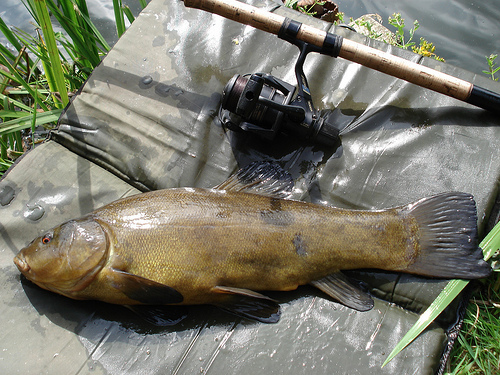

In [4]:
from PIL import Image

img = Image.fromarray(single_batch["image"][0])
img

Now, let’s download a pre-trained PyTorch Resnet model and get the required preprocessing transforms to preprocess the images prior to prediction.

In [5]:
from torchvision.models import ResNet18_Weights
from torchvision import transforms
from torchvision import models

weights = ResNet18_Weights.IMAGENET1K_V1

# Load the pretrained resnet model and move to GPU.
# Remove the `.cuda()` if using CPU.
model = models.resnet18(weights=weights).cuda()
model.eval()

imagenet_transforms = weights.transforms
transform = transforms.Compose([transforms.ToTensor(), imagenet_transforms()])

Then, we apply the transforms to our batch of images, and pass the batch to the model for inference, making sure to use the GPU device for inference.

All of the images in the batch have been correctly classified as "tench" which is a type of fish.

In [6]:
import torch

transformed_batch = [transform(image) for image in single_batch["image"]]
with torch.inference_mode():
    # Remove the `.cuda()` if doing inference on CPUs.
    prediction_results = model(torch.stack(transformed_batch).cuda())
    classes = prediction_results.argmax(dim=1).cpu()

labels = [weights.meta["categories"][i] for i in classes]
labels

['tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench']

## Step 3: Scaling up to the full Dataset with Ray Data

By using Ray Data, we can apply the same logic in the previous section to scale up to the entire dataset, leveraging all the GPUs in our cluster.

### Preprocessing

First let's convert the preprocessing code to Ray Data. We'll package the preprocessing code within a `preprocess_image` function. This function should take only one argument, which is a dict that contains a single image in the dataset, represented as a numpy array. We use the same `transform` function that was defined above and store the transformed image in a new `transformed_image` field.

In [7]:
from typing import Any, Dict

def preprocess_image(row: Dict[str, Any]):
    return {"original_image": row["image"], 
            "transformed_image": transform(row["image"]),}

Then we use the {meth}`map <ds.data.Dataset.map>` API to apply the function to the whole dataset. By using Ray Data's map, we can scale out the preprocessing to all the resources in our Ray cluster Note, the `map` method is lazy, it won't perform execution until we start to consume the results.

In [8]:
transformed_ds = ds.map(preprocess_image)

[2023-05-23 18:50:07] [Ray Data] WARNING ray.data.dataset::The `map`, `flat_map`, and `filter` operations are unvectorized and can be very slow. If you're using a vectorized transformation, consider using `.map_batches()` instead.


### Model Inference

Next, let's convert the model inference part. Compared with preprocessing, model inference has 2 differences:
1. Model loading and initialization is usually expensive. 
1. Model inference can be optimized with hardware acceleration if we process data in batches. Using larger batches improves GPU utilization and the overall runtime of the inference job.

Thus, we convert the model inference code to the following `ResnetModel` class. In this class, we put the expensive model loading and initialization code in the `__init__` constructor, which will run only once. And we put the model inference code in the `__call__` method, which will be called for each batch.

The `__call__` method takes a batch of data items, instead of a single one. In this case, the batch is also a dict that has one key named "image", and the value is a Numpy array of images represented in `np.ndarray` format. We reuse the same inferencing logic from step 2.

In [29]:
from typing import Dict
import numpy as np
import torch

class ResnetModel:
    def __init__(self):
        self.weights = ResNet18_Weights.IMAGENET1K_V1
        self.model = models.resnet18(self.weights).cuda()
        self.model.eval()

    def __call__(self, batch: Dict[str, np.ndarray]):
        # Convert the numpy array of images into a PyTorch tensor.
        torch_batch = torch.from_numpy(batch["transformed_image"])
        # Move the tensor batch to GPU if available.
        if torch.cuda.is_available():
            torch_batch = torch_batch.cuda()
        with torch.inference_mode():
            prediction = self.model(torch_batch)
            predicted_classes = prediction.argmax(dim=1).detach().cpu()
            predicted_labels = [self.weights.meta["categories"][i] for i in predicted_classes]
            return {"predicted_label": predicted_labels, "original_image": batch["original_image"]}

Then we use the {meth}`map_batches <ray.data.Dataset.map_batches>` API to apply the model to the whole dataset. 

The first parameter of {meth}`map_batches <ray.data.Dataset.map_batches>` is the user-defined function (UDF), which can either be a function or a class. In this case, we use a class-based UDF which is run as long-running [Ray actors](https://docs.ray.io/en/latest/ray-core/key-concepts.html#actors). For class-based UDFs, we use the `compute` argument to specify {class}`ActorPoolStrategy <ray.data.dataset_internal.compute.ActorPoolStrategy>` with the number of parallel actors. 

The `batch_size` argument indicates the number of images in each batch.
The `num_gpus` argument specifies the number of GPUs needed for each `ResnetModel` instance. In this case, we want 1 GPU for each model replica. If you are doing CPU inference, you can remove the `num_gpus=1`.

In [30]:
predictions = transformed_ds.map_batches(
    ResnetModel,
    compute=ray.data.ActorPoolStrategy(size=4), # Use 4 GPUs. Change this number based on the number of GPUs in your cluster.
    num_gpus=1,  # Specify 1 GPU per model replica.
    batch_size=1024 # Use the largest batch size that can fit on our GPUs
)

### Verify and Save Results

Let's take a small batch and verify the results.

In [ ]:
prediction_batch = predictions.take_batch(5)

We see that all the images are correctly classified as "tench", which is a type of fish.

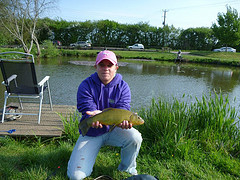

Label:  tench


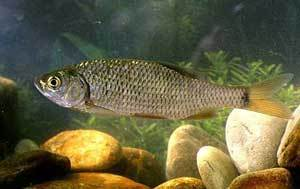

Label:  tench


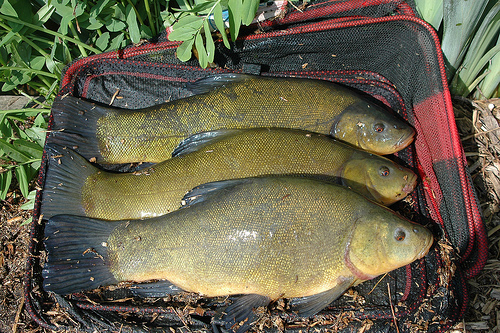

Label:  tench


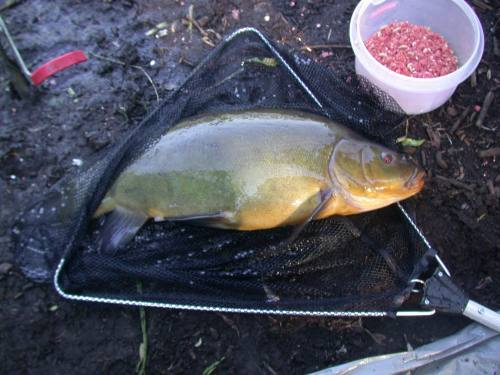

Label:  tench


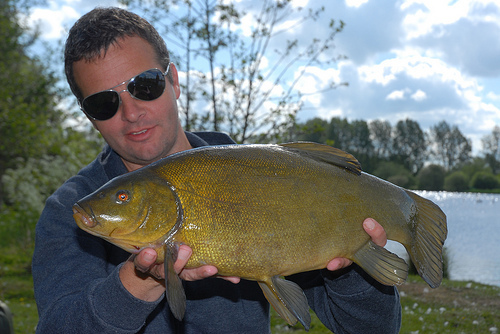

Label:  tench


In [35]:
from PIL import Image

for image, prediction in zip(prediction_batch["original_image"], prediction_batch["predicted_label"]):
    img = Image.fromarray(image)
    display(img)
    print("Label: ", prediction)

If the samples look good, we can proceed with saving the results to an external storage, e.g., S3 or local disks. See [Ray Data Input/Output](https://docs.ray.io/en/latest/data/api/input_output.html) for all supported stoarges and file formats.

```python
ds.write_parquet("local://tmp/inference_results")
```